#Import Libraries

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import re
import spacy
import pandas as pd
from IPython.display import display
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from IPython.display import IFrame
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#Data Loading

In [2]:
#Load DataSet
ufo = pd.read_csv('/kaggle/input/ufo-sightings/complete.csv', on_bad_lines='skip')


#DataCleaning

In [3]:
#Check the dataset
ufo.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [4]:
ufo['comments'].unique()

array(['This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit',
       '1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime.',
       'Green/Orange circular disc over Chester&#44 England', ...,
       '2 witnesses 2  miles apart&#44 Red &amp; White Elongated-Cigar Shaped Flashing lights&#44 NW of Oklahoma City',
       'On September ninth my wife and i noticed strange lights in the sky. Two white lights and a red light. I had noticed this the night befo',
       'Hovering object lit with red and white lights&#44 no engine sounds&#44 no directional movement.'],
      dtype=object)

In [5]:
#Check the shape of the dataset
ufo.shape

(88679, 11)

In [6]:
#Check the basic information of the dataset
ufo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88679 entries, 0 to 88678
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              88679 non-null  object 
 1   city                  88679 non-null  object 
 2   state                 81270 non-null  object 
 3   country               76314 non-null  object 
 4   shape                 85757 non-null  object 
 5   duration (seconds)    88677 non-null  object 
 6   duration (hours/min)  85660 non-null  object 
 7   comments              88644 non-null  object 
 8   date posted           88679 non-null  object 
 9   latitude              88679 non-null  object 
 10  longitude             88679 non-null  float64
dtypes: float64(1), object(10)
memory usage: 7.4+ MB


In [7]:
#Check Nan values
ufo.isnull().sum()

datetime                    0
city                        0
state                    7409
country                 12365
shape                    2922
duration (seconds)          2
duration (hours/min)     3019
comments                   35
date posted                 0
latitude                    0
longitude                   0
dtype: int64

In [8]:
#Drop Nan values
ufo.dropna(inplace=True)

In [9]:
#Rename columns for clarity
ufo = ufo.rename(columns = {'duration (seconds)': 'duration_second',
            'duration (hours/min)': 'duration_min_hours',
            'date posted': 'date_posted'})

In [10]:
# Convert the 'datetime' column to datetime format
ufo['datetime'] = pd.to_datetime(ufo['datetime'], errors='coerce')
ufo['date_posted'] = pd.to_datetime(ufo['date_posted'], errors='coerce')

In [11]:
#Check Nan values
ufo.isnull().sum()

datetime              546
city                    0
state                   0
country                 0
shape                   0
duration_second         0
duration_min_hours      0
comments                0
date_posted             0
latitude                0
longitude               0
dtype: int64

In [12]:
#Drop Nan values
ufo.dropna(inplace=True)

In [13]:
## Extract components from columns and create new columns
column = ['datetime', 'date_posted']

for col in column:
  ufo[col] = ufo[col].apply(lambda x: x.replace(hour=0) if pd.notnull(x) and x.hour == 24 else x)

ufo['datetime_month'] = ufo['datetime'].dt.month.astype(int)
ufo['datetime_day'] = ufo['datetime'].dt.day.astype(int)
ufo['datetime_year'] = ufo['datetime'].dt.year.astype(int)
ufo['datetime_hour'] = ufo['datetime'].dt.hour.astype(int)
ufo['datetime_min'] = ufo['datetime'].dt.minute.astype(int)

ufo['date_posted_month'] = ufo['date_posted'].dt.month
ufo['date_posted_day'] = ufo['date_posted'].dt.day
ufo['date_posted_year'] = ufo['date_posted'].dt.year
ufo['date_posted_hour'] = ufo['date_posted'].dt.hour
ufo['date_posted_min'] = ufo['date_posted'].dt.minute

# Drop the original 'datetime' and 'date_posted' columns
ufo = ufo.drop(columns=['date_posted', 'datetime'], axis=1)

In [14]:
# Create a new column 'comments_len' containing the number of words in the 'comments' column
ufo['comments_len'] = ufo['comments'].map(lambda x: len(x.split()) if isinstance(x, str) else 0)
#ufo.drop(columns='comments', inplace=True)

In [15]:
# Create a new column 'duration_minutes' containing time minut
def extract_minutes(comment):
    if pd.isnull(comment):
        return None

    numbers = re.findall(r'\d+', comment)

    if len(numbers) == 1:
        return int(numbers[0])
    elif len(numbers) == 2:
        return (int(numbers[0]) + int(numbers[1])) / 2
    else:
        return None

ufo['duration_minutes'] = ufo['duration_min_hours'].apply(extract_minutes)
print(ufo[['duration_min_hours', 'duration_minutes']])

#Drop the original column
ufo.drop(columns='duration_min_hours', inplace=True)


      duration_min_hours  duration_minutes
0             45 minutes              45.0
3               1/2 hour               1.5
4             15 minutes              15.0
5              5 minutes               5.0
7             20 minutes              20.0
...                  ...               ...
88674               hour               NaN
88675          5 seconds               5.0
88676         17 minutes              17.0
88677           2 nights               2.0
88678     still occuring               NaN

[68982 rows x 2 columns]


In [16]:
#Drop Nan
ufo.dropna(inplace=True)


In [17]:
#Grouping values from the Shape column
shape = {
    'changing': ['changed', 'changing'],
    'chevron': ['chevron', 'crescent'],
    'cylinder': ['cigar', 'cylinder'],
    'round': ['circle', 'disk', 'egg', 'hexagon', 'oval', 'round', 'sphere'],
    'square': ['cross', 'diamond', 'rectangle'],
    'triangle': ['cone', 'delta', 'pyramid', 'triangle'],
    'light': ['fireball', 'flare', 'flash', 'light'],
    'otherSeen': ['other'],
    'otherSeen2': ['dome', 'formation', 'teardrop', 'unknown']
}

for ufo_shape, ali in shape.items():
    ufo.loc[ufo['shape'].isin(ali), 'ufo_shape'] = ufo_shape

#Drop original column
ufo.drop(columns='shape', inplace=True)

In [18]:
#Check DataSet
ufo.head()

,city,state,country,duration_second,comments,latitude,longitude,datetime_month,datetime_day,datetime_year,datetime_hour,datetime_min,date_posted_month,date_posted_day,date_posted_year,date_posted_hour,date_posted_min,comments_len,duration_minutes,ufo_shape
0,san marcos,tx,us,2700,This event took place in early fall around 194...,29.8830556,-97.941111,10,10,1949,20,30,4,27,2004,0,0,24,45.0,cylinder
3,edna,tx,us,20,My older brother and twin sister were leaving ...,28.9783333,-96.645833,10,10,1956,21,0,1,17,2004,0,0,26,1.5,round
4,kaneohe,hi,us,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,21.4180556,-157.803611,10,10,1960,20,0,1,22,2004,0,0,25,15.0,light
5,bristol,tn,us,300,My father is now 89 my brother 52 the girl wit...,36.5950000,-82.188889,10,10,1961,19,0,4,27,2007,0,0,29,5.0,round
7,norwalk,ct,us,1200,A bright orange color changing to reddish colo...,41.1175000,-73.408333,10,10,1965,23,45,10,2,1999,0,0,16,20.0,round


In [19]:
#Convert type columns from object to float
ufo['latitude'] = ufo['latitude'].astype('float64')
ufo['duration_second'] = ufo['duration_second'].astype('float64')

#Create list with columns dtype object
object_col = [x for x in ufo.columns if ufo[x].dtype == 'object']

#After an initial analysis of the dataset, the following actions were taken to facilitate data visualization in the next stage:

* Some columns were renamed for easier readability.
* The 'datetime' column was split into distinct columns.
* The 'comments_len' column was transformed into a numeric column.
* Values in the 'shape' column were grouped into a new column.
* Additionally, some columns that did not have significant importance were removed following the aforementioned preprocessing.
* NaN values were not replaced with other values but were removed, considering that the number of rows allows for this.

#Feature EDA

In [20]:
#A small statistic of the DataSet
ufo.describe().T

,count,mean,std,min,25%,50%,75%,max
duration_second,63448.0,6174.898491,520873.870014,0.000000,30.000000,180.000000,600.000000,8.280000e+07
latitude,63448.0,38.701188,5.843337,-37.813938,34.195278,39.245556,42.336944,7.270000e+01
longitude,63448.0,-95.304072,18.492786,-170.478889,-114.259722,-89.588889,-80.397500,1.530995e+02
datetime_month,63448.0,6.871107,3.231824,1.000000,4.000000,7.000000,10.000000,1.200000e+01
datetime_day,63448.0,15.057606,8.905426,1.000000,7.000000,15.000000,22.000000,3.100000e+01
datetime_year,63448.0,2004.306976,10.229098,1910.000000,2002.000000,2007.000000,2011.000000,2.014000e+03
datetime_hour,63448.0,15.785241,7.573919,0.000000,11.000000,19.000000,21.000000,2.300000e+01
datetime_min,63448.0,17.842075,17.926647,0.000000,0.000000,15.000000,30.000000,5.900000e+01
date_posted_month,63448.0,6.714853,3.482197,1.000000,4.000000,7.000000,10.000000,1.200000e+01
date_posted_day,63448.0,15.236272,8.816154,1.000000,8.000000,14.000000,22.000000,3.100000e+01


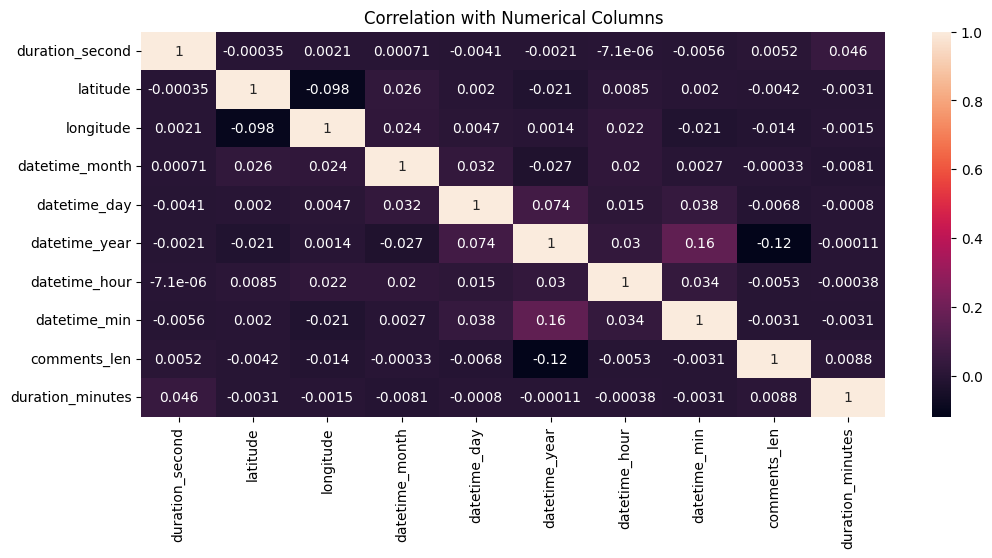

In [21]:
# Corelation columns
plt.figure(figsize=(12, 5))
sns.heatmap(ufo.select_dtypes(include=['int64', 'float64']).corr(), annot=True)
plt.title('Correlation with Numerical Columns')
plt.show()

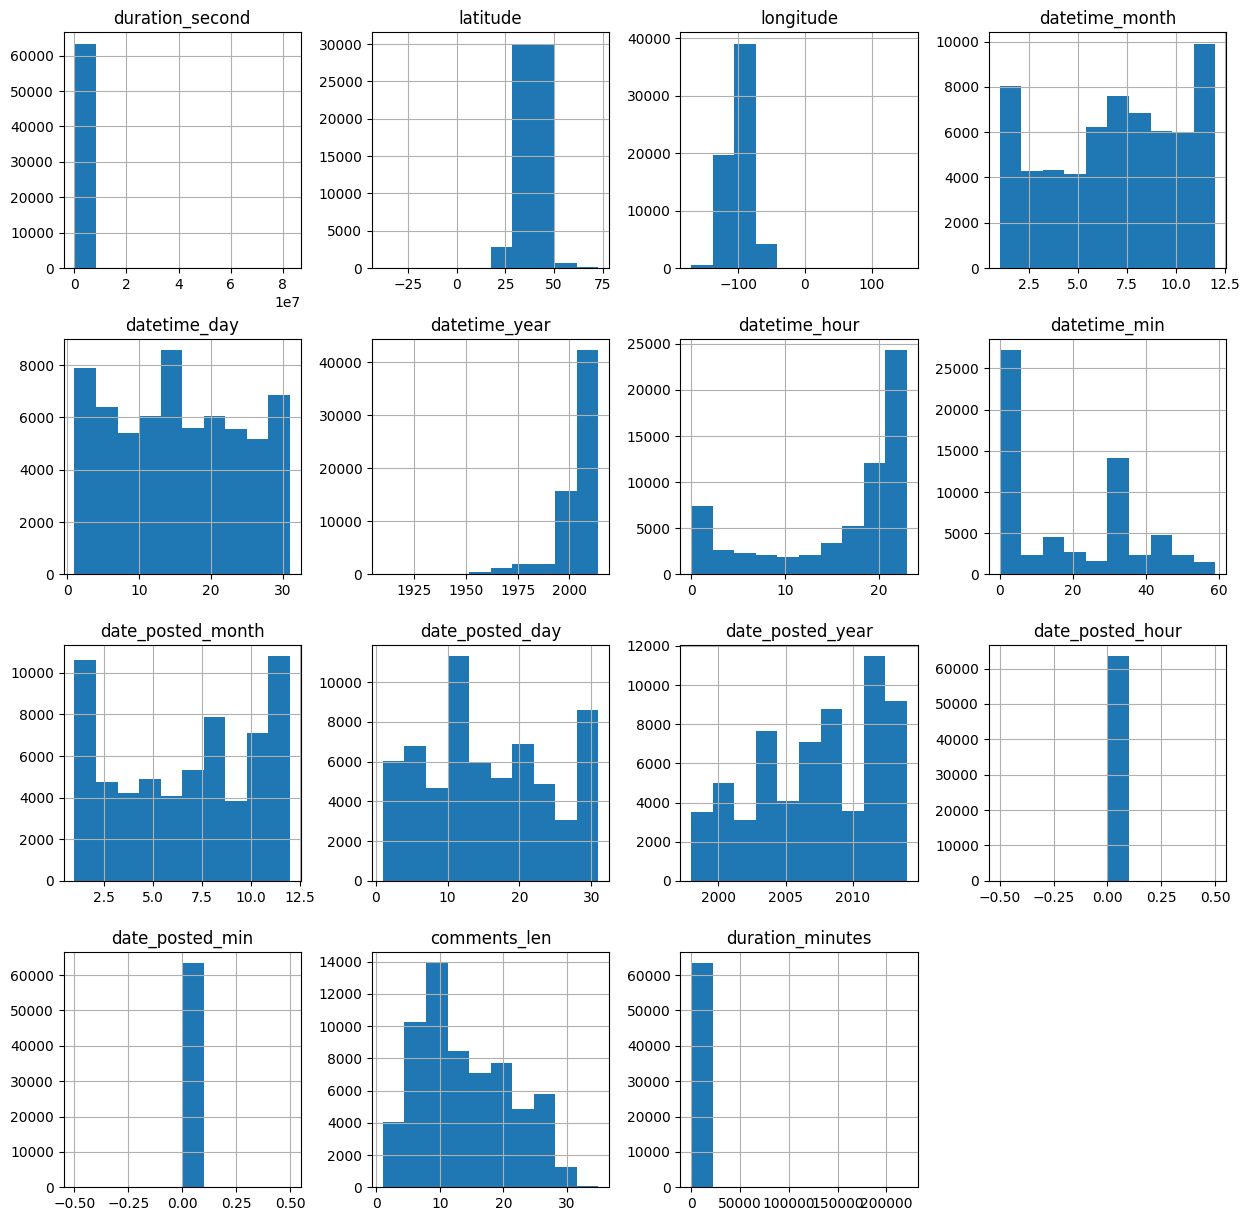

In [22]:
#Plot histograms of columns
ufo.hist(figsize=(15, 15))
plt.show()

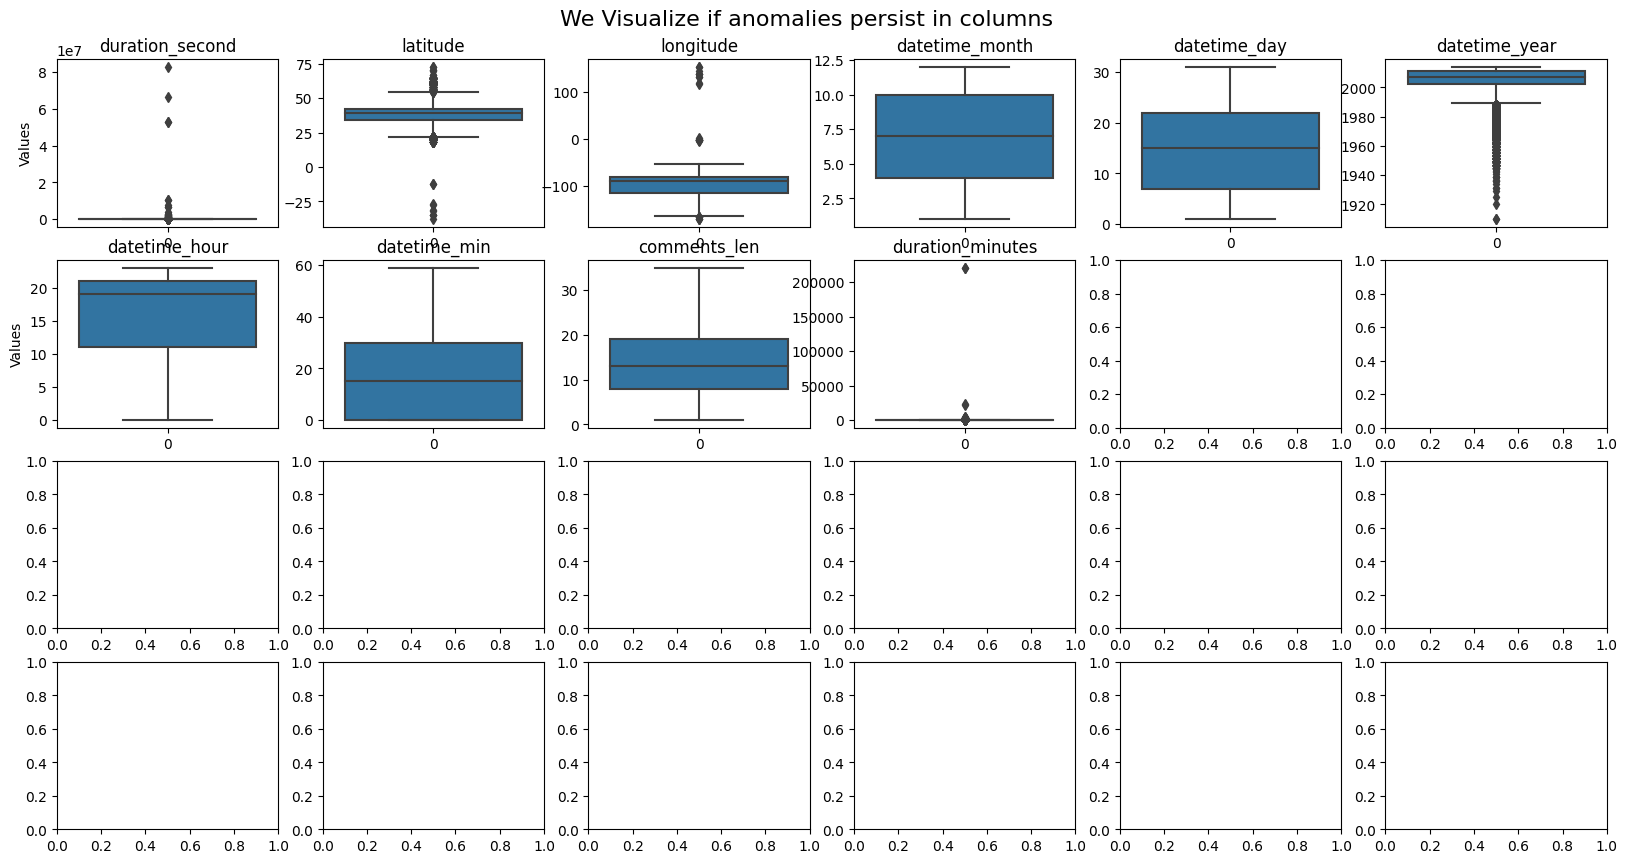

In [23]:
#Boxplot for visualisation outliers
def boxplots_custom(dataset, columns_list, rows, cols, suptitle,size=(20,10)):
    fig, axs = plt.subplots(rows, cols,  figsize=size)
    fig.suptitle(suptitle,y=0.93, size=16)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        if i % cols == 0:
            axs[i].set_ylabel('Values')
        sns.boxplot( data=dataset[data], orient='v', ax=axs[i])
        axs[i].set_title(data)

boxplots_custom(dataset=ufo, columns_list=ufo.select_dtypes(include=('int64', 'float64')).columns.tolist(), rows=4, cols=6, suptitle='We Visualize if anomalies persist in columns')

In [24]:
#Remove outliers of 2 columns
print(f'Numbers rows before deleting outliers [duration_second]: {len(ufo)}')
ufo = ufo[ufo['duration_second'] < 50000000.0]
print(f'Numbers rows after deleting outliers [duration_second]: {len(ufo)}')


print(f'Numbers rows before deleting outliers [duration_minutes]: {len(ufo)}')
ufo = ufo[ufo['duration_minutes'] < 200000]
print(f'Numbers rows after deleting outliers [duration_minutes]: {len(ufo)}')

Numbers rows before deleting outliers [duration_second]: 63448
Numbers rows after deleting outliers [duration_second]: 63444
Numbers rows before deleting outliers [duration_minutes]: 63444
Numbers rows after deleting outliers [duration_minutes]: 63442


#The outliers were also removed to avoid affecting the results of the analysis.

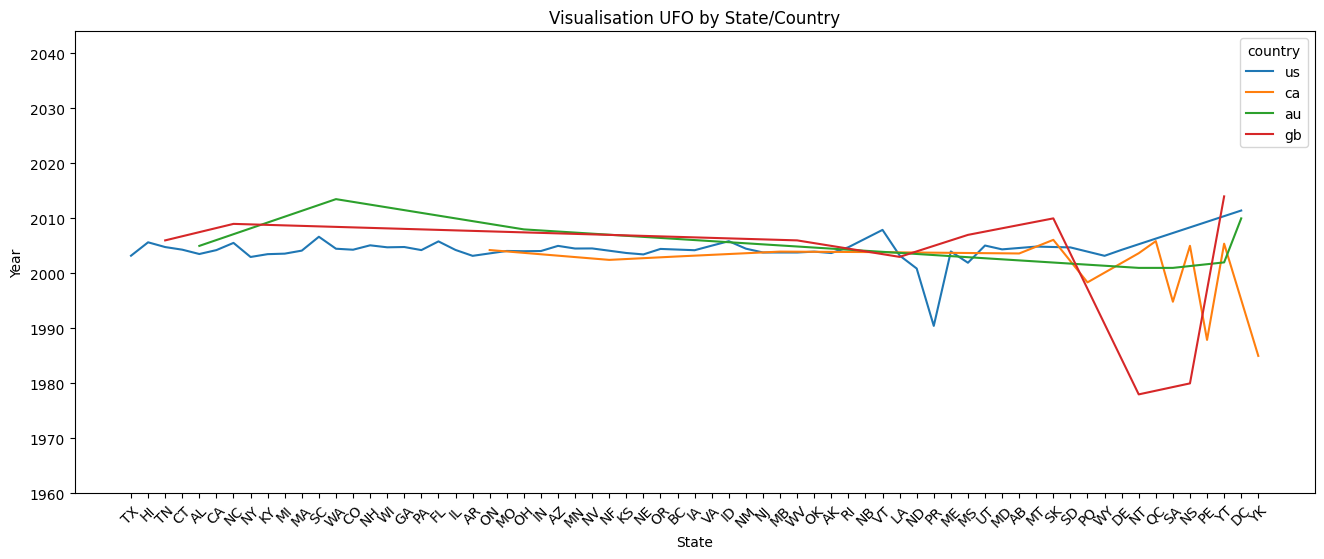

In [25]:
#In which countries and states are the most sightings
plt.figure(figsize=(16,6))
sns.lineplot(x=ufo['state'].str.upper(), y=ufo['datetime_year'], data=ufo, ci=None, hue='country')
plt.title('Visualisation UFO by State/Country')
plt.xlabel('State')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.ylim(1960, ufo['datetime_year'].max()+30)
plt.show()

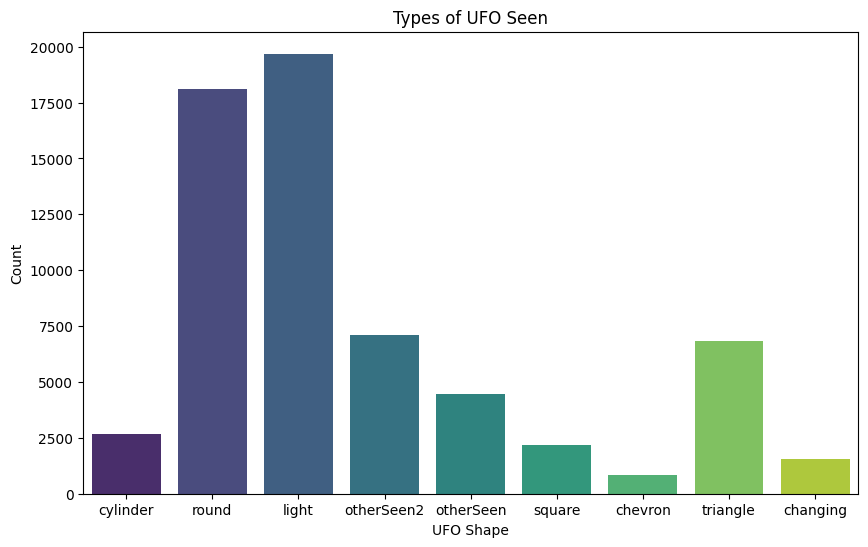

In [26]:
#Visualizing the most frequently observed UFO shape
plt.figure(figsize=(10, 6))
sns.countplot(x='ufo_shape', data=ufo, palette='viridis')
plt.xlabel('UFO Shape')
plt.ylabel('Count')
plt.title('Types of UFO Seen')
plt.show()


In [27]:
ufo['ufo_shape'].value_counts()

ufo_shape
light         19687
round         18130
otherSeen2     7097
triangle       6815
otherSeen      4458
cylinder       2667
square         2197
changing       1566
chevron         825
Name: count, dtype: int64

In [28]:
#Create a new column by grouped visualization of UFO sightings during the day or night

ufo['time_of_day'] = ''
ufo.loc[(ufo['datetime_hour'] >= 6) & (ufo['datetime_hour'] <= 18), 'time_of_day'] = 'Day'
ufo.loc[(ufo['datetime_hour'] > 18) | (ufo['datetime_hour'] < 6), 'time_of_day'] = 'Night'
obsev_by_time_of_day = ufo['time_of_day'].value_counts()

ufo['datetime_season'] = ''
ufo.loc[(ufo['datetime_month'] >= 3) & (ufo['datetime_month'] <= 5), 'datetime_season'] = 'spring'
ufo.loc[(ufo['datetime_month'] >= 6) & (ufo['datetime_month'] <= 8), 'datetime_season'] = 'summer'
ufo.loc[(ufo['datetime_month'] >= 9) & (ufo['datetime_month'] <= 11), 'datetime_season'] = 'autumn'
ufo.loc[(ufo['datetime_month'] == 12) | (ufo['datetime_month'] == 1) | (ufo['datetime_month'] == 2), 'datetime_season'] = 'winter'
obsev_by_time_of_season = ufo['datetime_season'].value_counts()

print(obsev_by_time_of_day)
print(obsev_by_time_of_season)

time_of_day
Night    47736
Day      15706
Name: count, dtype: int64
datetime_season
summer    20666
autumn    17513
spring    12759
winter    12504
Name: count, dtype: int64


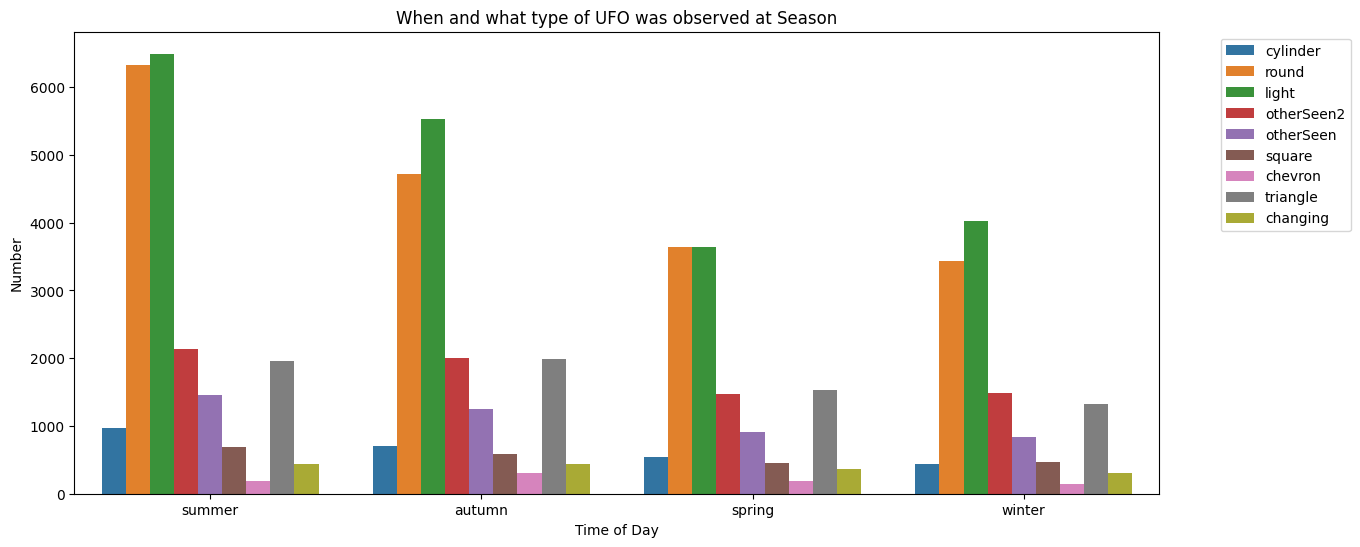

In [29]:
#Observation by time of Season what type of UFO

plt.figure(figsize=(14, 6))
sns.countplot(data=ufo, x='datetime_season', hue='ufo_shape', order=ufo['datetime_season'].value_counts().index)
sns.color_palette("magma")
plt.title('When and what type of UFO was observed at Season')
plt.xlabel('Time of Day')
plt.ylabel('Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

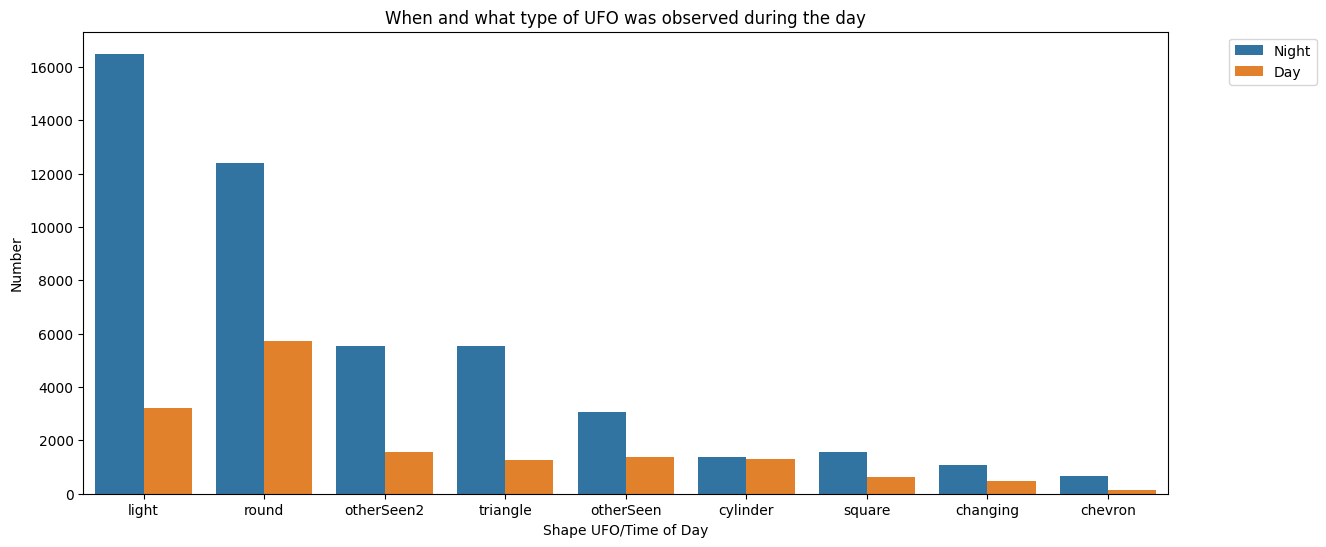

In [30]:
#Observation by time of day what type of UFO

plt.figure(figsize=(14, 6))
sns.countplot(data=ufo, x='ufo_shape', hue='time_of_day', order=ufo['ufo_shape'].value_counts().index)
sns.color_palette("rocket")
plt.title('When and what type of UFO was observed during the day')
plt.xlabel('Shape UFO/Time of Day')
plt.ylabel('Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

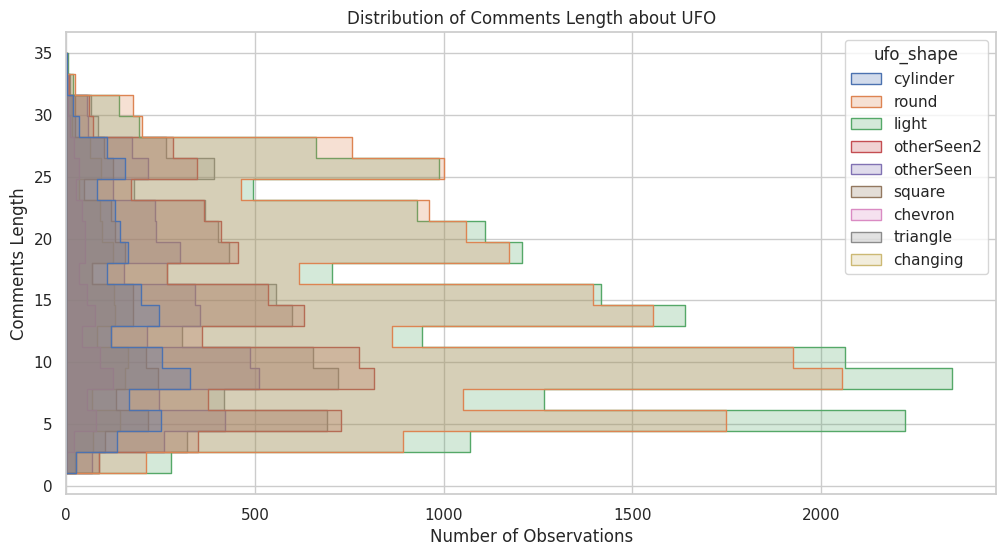

In [31]:
# Horizontal Histogram of Comments Length
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.histplot(y=ufo['comments_len'], bins=20, kde=False, color='blue', hue=ufo['ufo_shape'],
             element="step", stat="count", common_norm=False)
plt.ylabel("Comments Length")
plt.xlabel("Number of Observations")
plt.title("Distribution of Comments Length about UFO")

plt.show()

In [32]:
#This code utilizes spaCy for semantic analysis of comments related to UFO sightings

nlp = spacy.load("en_core_web_sm")

general_nouns = ['location', 'area', 'region', 'territory', 'space', 'place',
                 'spot', 'site', 'beach']

specific_nouns = ['field', 'desert', 'mountain', 'forest', 'city', 'village',
                  'ocean', 'river', 'lake', 'surroundings', 'countryside',
                  'landscape']

ufo_context_terms = ['aviation', 'restricted', 'high altitude', 'airport', 'air',
                     'ufo sighting location', 'hotspot','military', 'base',
                     'government', 'defense', 'center', 'secure', 'strategic',
                     'high security', 'security', 'intelligence headquarters',
                     'pentagon', 'white house']

emotions = ['amazement', 'wonder', 'fear', 'excitement', 'distrust', 'hatred',
            'displeasure', 'misunderstanding', 'concern', 'hope', 'delight',
            'curiosity', 'helplessness', 'happiness', 'distrust', 'panic',
            'aversion', 'worry', 'awe', 'confusion',
            'love', 'gratitude', 'joy', 'contentment', 'grace', 'serenity',
            'euphoria', 'optimism', 'pride', 'satisfaction', 'compassion',
            'anger', 'disgust', 'despair', 'grief', 'guilt', 'shame',
            'anxiety', 'regret', 'sadness', 'loneliness', 'frustration']



comments = ufo['comments'].astype(object)


chunk_lst_general = []
chunk_lst_specific = []
entity_lst = []
emotions_lst = []

for text in comments:
    doc = nlp(text)

    for chunk in doc.noun_chunks:
        if chunk.text.upper() in general_nouns or chunk.text.lower() in general_nouns or chunk.text in general_nouns:
            chunk_lst_general.append(chunk.text)
            print(f"General noun for locations: {chunk.text}")

        elif chunk.text.upper() in specific_nouns or chunk.text.lower() in specific_nouns or chunk.text in specific_nouns:
            chunk_lst_specific.append(chunk.text)
            print(f"Specific noun for locations: {chunk.text}")

        elif chunk.text.upper() in emotions or chunk.text.lower() in emotions or chunk.text in emotions:
            emotions_lst.append(chunk.text)
            print(f"Emotions noun for locations: {chunk.text}")



    for entity in doc.ents:
        if entity.text.upper() in ufo_context_terms or entity.text.lower() in ufo_context_terms or entity.text in ufo_context_terms:
            entity_lst.append(entity.text)
            print(f"UFO context-specific term: {entity.text}")

General noun for locations: place
Specific noun for locations: city
General noun for locations: Area
General noun for locations: space
General noun for locations: location
Specific noun for locations: ocean
Specific noun for locations: city
Specific noun for locations: field
General noun for locations: space
General noun for locations: place
Specific noun for locations: field
Specific noun for locations: field
General noun for locations: space
Specific noun for locations: ocean
General noun for locations: area
Specific noun for locations: field
Specific noun for locations: lake
Specific noun for locations: field
Specific noun for locations: lake
Specific noun for locations: river
Specific noun for locations: city
Specific noun for locations: lake
Specific noun for locations: ocean
General noun for locations: space
General noun for locations: place
General noun for locations: place
General noun for locations: space
General noun for locations: area
Specific noun for locations: ocean
Spec

In [33]:
# Create lowercased lists of words from different sources
general_words = [txt.lower() for txt in chunk_lst_general]
specific_words = [txt.lower() for txt in chunk_lst_specific]
entity_words = [txt.lower() for txt in entity_lst]
emotion_words = [txt.lower() for txt in emotions_lst]

# Combine
key_word = general_words + specific_words + entity_words

# Create a pandas DataFrame
df_key_word = pd.DataFrame({'location': key_word})
df_emotions = pd.DataFrame({'emotion': emotion_words})

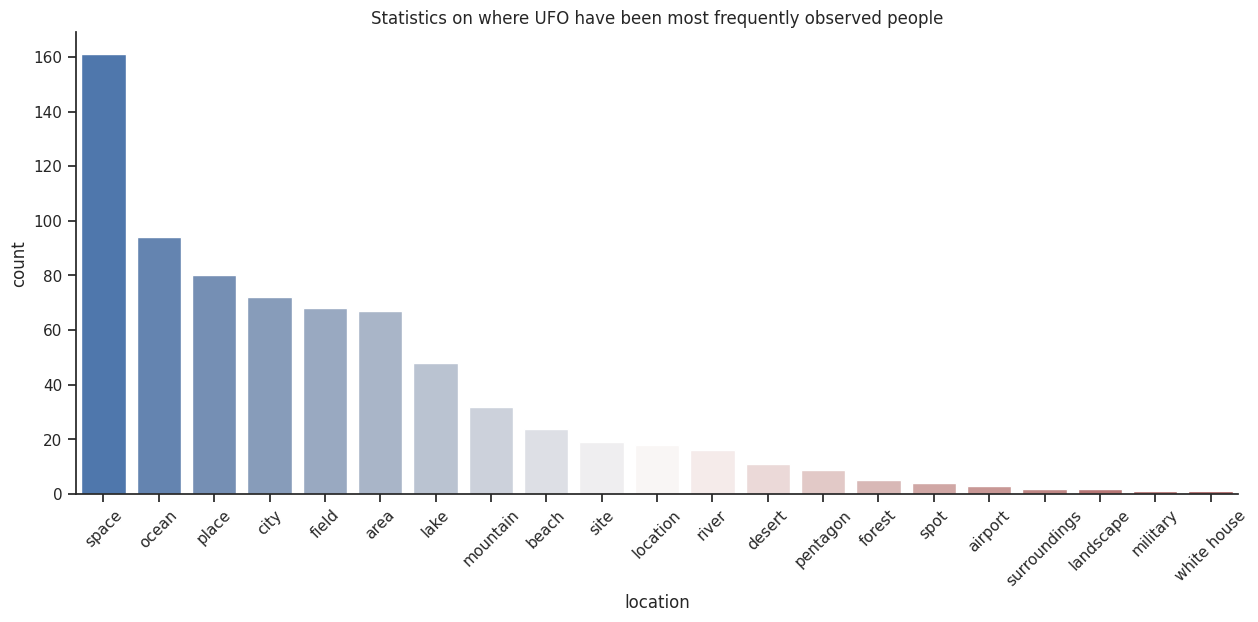

In [34]:
# Create a countplot visualised where UFO most frequently observed people

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.subplots(figsize=(15, 6))

sns.countplot(data=df_key_word, x="location", palette="vlag", order=df_key_word['location'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Statistics on where UFO have been most frequently observed people')
plt.show()


In [35]:
# Group emotions in the DataFrame
df_emo = df_emotions.groupby('emotion').size().reset_index(name='emotion_count')

# Calculate the percentage of each emotion
df_emo['percentage_emotion'] = round(df_emo['emotion_count'] * 100 / df_emo['emotion_count'].sum(), 1)

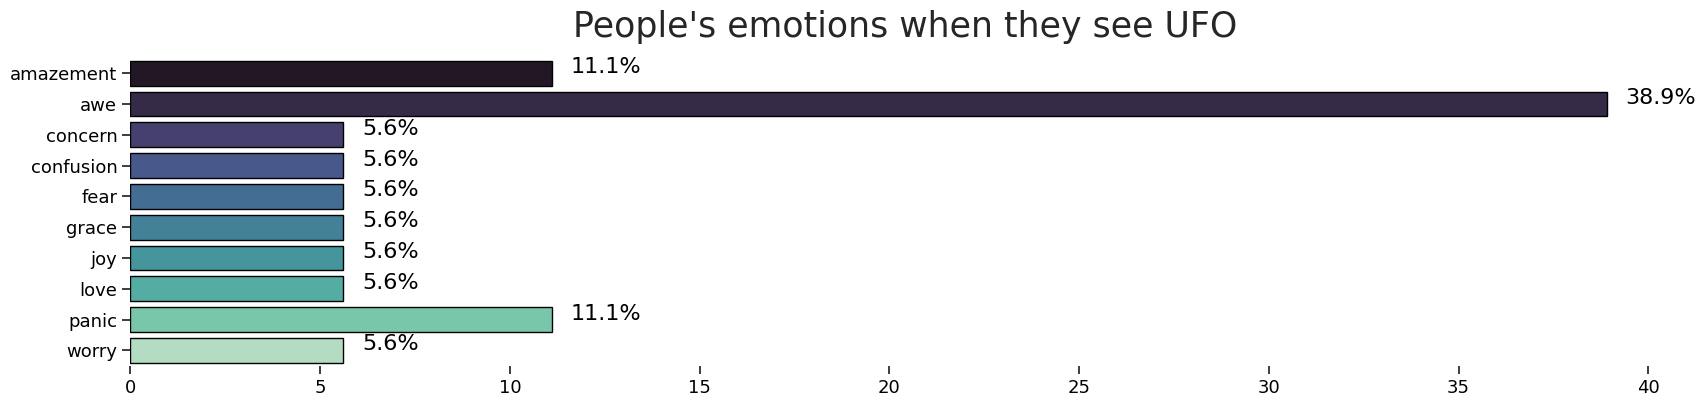

In [36]:
# Creating a barplot to visualize on a graph the emotions people experience when they see UFOs

fig = plt.figure(figsize=(20, 4))
a = sns.barplot(data=df_emo, x='percentage_emotion', y='emotion',
                palette='mako', linestyle="-", linewidth=1, edgecolor="black")
plt.xticks(size=13, color='black')
plt.yticks(size=13, color='black')
plt.title("People's emotions when they see UFO", pad=15, size=25)
plt.xlabel('')
plt.ylabel('')

for i, v in enumerate(df_emo['percentage_emotion']):
    a.text(v + 0.5, i, f"{v}%",  color='black', fontsize=16)

for j in ['right', 'top', 'left', 'bottom']:
    a.spines[j].set_visible(False)

plt.show()


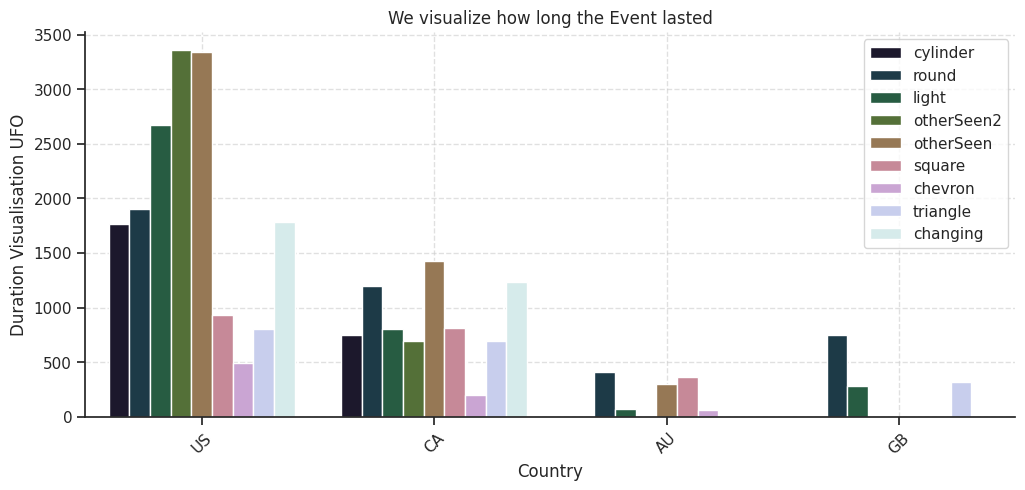

In [37]:
#Visualized duration of UFO sightings in the sky by Country
plt.figure(figsize=(12, 5))
sns.barplot(x=ufo['country'].str.upper(), y=ufo['duration_second'], ci=None, palette='cubehelix', hue=ufo['ufo_shape'])

plt.title('We visualize how long the Event lasted')
plt.xlabel('Country')
plt.ylabel('Duration Visualisation UFO')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


#After analyzing the data, we can draw the following conclusions:

* UFO was most frequently observed in the Summer Season and in the  countries USA and GB.
* The longest duration of UFO sightings was recorded in CA and the USA.
* The majority of observations were noted during the night, raising doubts about the shape of the UFO.
* The most commonly reported UFO types are Round, Light (in the sky), and Triangle.
* The most active in writing comments are from the country AU, with frequent mentions of the round, square and light UFO type; in the second place is GB, with comments regarding a light in the sky.
* During the night, the most frequently observed types of UFO were a light in the sky and a round UFO; during the day, the same types of UFO were mentioned, namely a light in the sky and a round UFO.
* As it can be observed, those who have had encounters with UFOs generally exhibit a very positive attitude and pronounced enthusiasm towards these experiences, while reactions of fear and unease seem to be less widespread. According to the statistical analysis based on comments, it is found that approximately 66.8% of people have described these encounters as full of excitement and positivity, while those who have expressed negative reactions, characterized by fear and unease, make up around 34.5%.

# Data Pre-Processing

In [38]:
# Copy the UFO dataset and identify columns with object data type

ufo_cop = ufo.copy()
object_columns = list(ufo_cop.select_dtypes(include='object'))

In [39]:
# Encoding Object Columns

le = LabelEncoder()

for col in object_columns:
  ufo_cop[col] = le.fit_transform(ufo_cop[col])


In [40]:
# Check DAtaSet
ufo_cop.head(3)

,city,state,country,duration_second,comments,latitude,longitude,datetime_month,datetime_day,datetime_year,...,date_posted_month,date_posted_day,date_posted_year,date_posted_hour,date_posted_min,comments_len,duration_minutes,ufo_shape,time_of_day,datetime_season
0,9070,57,3,2700.0,45594,29.883056,-97.941111,10,10,1949,...,4,27,2004,0,0,24,45.0,2,1,0
3,2967,57,3,20.0,31888,28.978333,-96.645833,10,10,1956,...,1,17,2004,0,0,26,1.5,6,1,0
4,5023,13,3,900.0,7969,21.418056,-157.803611,10,10,1960,...,1,22,2004,0,0,25,15.0,3,1,0


# We will train a regression algorithm to predict the latitude and longitude of locations where UFOs might appear in various cities around the world

In [41]:
# Create target variable and feature Matrix X

X = ufo_cop.drop(columns=['latitude', 'longitude'], axis=1)
y_latitude = ufo_cop['latitude']
y_longitude = ufo_cop['longitude']

In [42]:
# Split the dataset into training and testing sets

X_train, X_test, y_train_latitude, y_test_latitude, y_train_longitude, y_test_longitude = train_test_split(X, y_latitude, y_longitude, test_size=0.2, random_state=1)
mms = MinMaxScaler()
X = mms.fit_transform(X)

In [43]:
# Initialize Random Forest Regressor models

"""param_grid = {
    'max_features' : ["auto", "sqrt", "log2"],
    'min_samples_split' : np.linspace(0.1, 1.0, 5),
     'max_depth' : [x for x in range(1,12)],
    'n_estimators' : [10, 50, 100]
    }

cv_latitude = GridSearchCV(estimator= RandomForestRegressor(), param_grid= param_grid, cv= 3, n_jobs= -1)
cv_latitude.fit(X_train, y_train_latitude)
best_param_latitude = cv_latitude.best_params_

cv_longitude = GridSearchCV(estimator= RandomForestRegressor(), param_grid= param_grid, cv= 3, n_jobs= -1)
cv_longitude.fit(X_train, y_train_longitude)
best_param_longitude = cv_longitude.best_params_"""


# Train the models
rf_latitude = RandomForestRegressor()
rf_latitude.fit(X_train, y_train_latitude)

rf_longitude = RandomForestRegressor()
rf_longitude.fit(X_train, y_train_longitude)

# Make predictions
y_pred_latitude_rf = rf_latitude.predict(X_test)
y_pred_longitude_rf = rf_longitude.predict(X_test)


# Evaluate the performance
mae_latitude_rf = mean_absolute_error(y_test_latitude, y_pred_latitude_rf)
mse_latitude_rf = mean_squared_error(y_test_latitude, y_pred_latitude_rf)
r2_latitude_rf = r2_score(y_test_latitude, y_pred_latitude_rf)

mae_longitude_rf = mean_absolute_error(y_test_longitude, y_pred_longitude_rf)
mse_longitude_rf = mean_squared_error(y_test_longitude, y_pred_longitude_rf)
r2_longitude_rf = r2_score(y_test_longitude, y_pred_longitude_rf)


# Print the evaluation metrics
print(f"mean_absolute_error latitude: {mae_latitude_rf}")
print(f"mean_squared_error latitude: {mse_latitude_rf}")
print(f"r2_score latitude: {r2_latitude_rf}\n")
print(f"mean_absolute_error longitude: {mae_longitude_rf}")
print(f"mean_squared_error longitude: {mse_longitude_rf}")
print(f"r2_score longitude: {r2_longitude_rf}")

mean_absolute_error latitude: 0.4890216746431219
mean_squared_error latitude: 0.7038059061712673
r2_score latitude: 0.9790930582407465

mean_absolute_error longitude: 0.7316742735467735
mean_squared_error longitude: 3.6616822575112433
r2_score longitude: 0.9890454031360734


# We chose the Random Forest model for regression due to its ability to handle large datasets and complex features. This algorithm provides robust and accurate results in regression problems with intricate data structures. Significant performance observed in our evaluations and alignment with test data have confirmed this choice

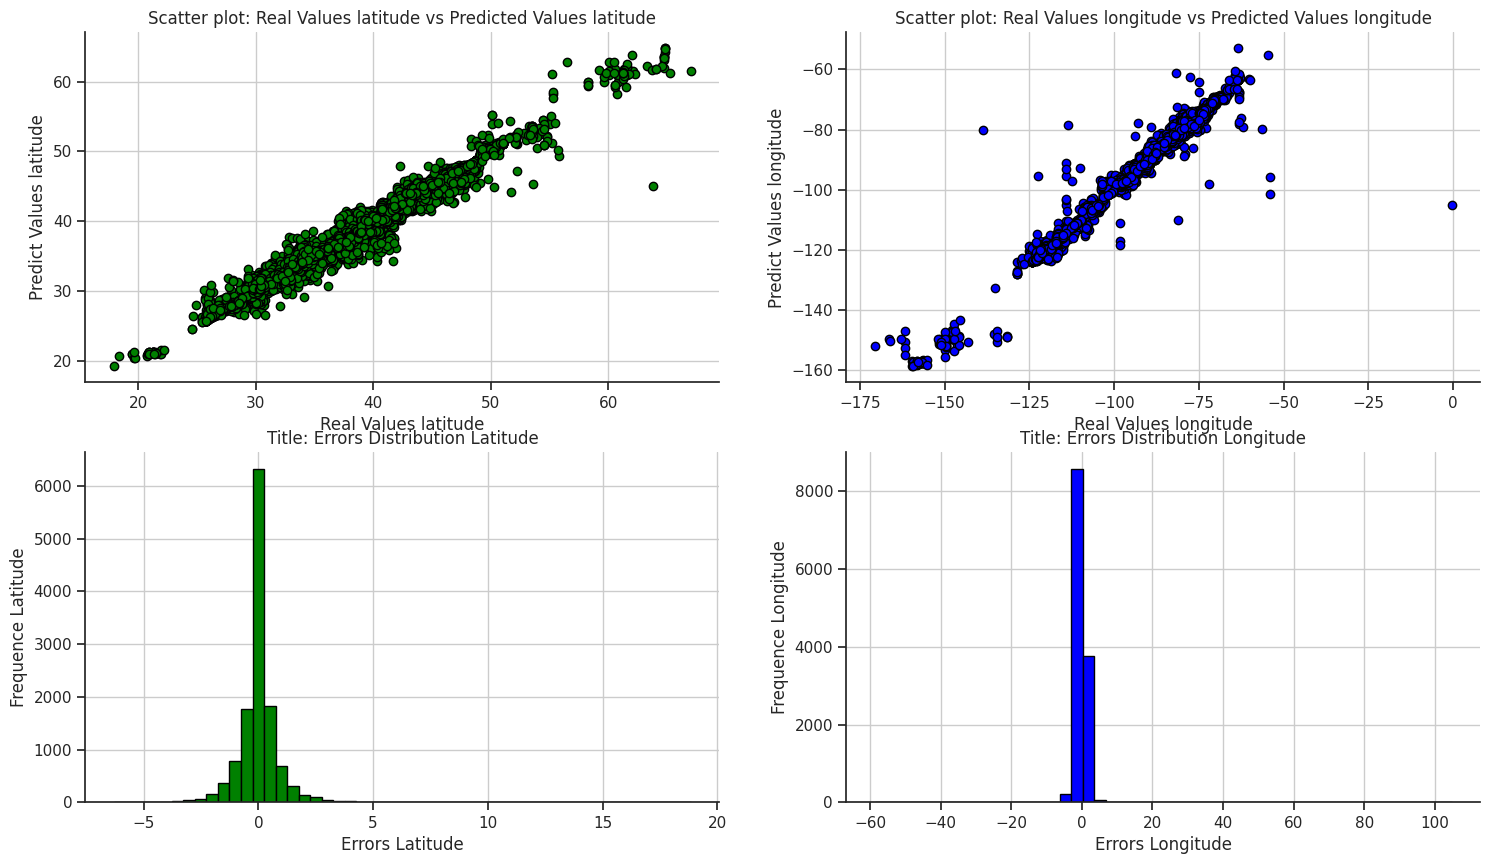

In [44]:
# Visualised Real Values, Predicted Values and Errors Distribution
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
plt.scatter(y_test_latitude, y_pred_latitude_rf, color= 'green', edgecolors='black')
plt.xlabel('Real Values latitude')
plt.ylabel('Predict Values latitude')
plt.title('Scatter plot: Real Values latitude vs Predicted Values latitude')
plt.grid()

plt.subplot(2, 2, 2)
plt.scatter(y_test_longitude, y_pred_longitude_rf, color= 'blue', edgecolors='black')
plt.xlabel('Real Values longitude')
plt.ylabel('Predict Values longitude')
plt.title('Scatter plot: Real Values longitude vs Predicted Values longitude')
plt.grid()




error_ml_latitude = y_test_latitude - y_pred_latitude_rf
plt.subplot(2, 2, 3)
plt.hist(error_ml_latitude, bins=50, edgecolor= 'black', color='green')
plt.xlabel('Errors Latitude')
plt.ylabel('Frequence Latitude')
plt.title('Title: Errors Distribution Latitude')
plt.grid()

error_ml_logitude = y_test_longitude - y_pred_longitude_rf
plt.subplot(2, 2, 4)
plt.hist(error_ml_logitude, bins=50, edgecolor= 'black', color='blue')
plt.xlabel('Errors Longitude')
plt.ylabel('Frequence Longitude')
plt.title('Title: Errors Distribution Longitude')
plt.grid()
plt.show()

* Scatterplot: This scatterplot graphically represents the model's performance and exhibits remarkable accuracy. Virtually all points form a straight diagonal line from the bottom-left corner to the top-right corner. This pattern suggests an excellent fit of the model to the data, highlighting a notable alignment.

* Histogram: The histogram graph provides insights into the frequency of differences between predicted and actual values of the model. Emphasizing symmetry, centrality, and dispersion, we observe that the histogram is centered around the value 0. This feature indicates a correct trend in the model overall, as most errors revolve around the central point.

In [45]:
df_pred_lat = pd.DataFrame({'predict_latitude_reg': y_pred_latitude_rf})
df_pred_lon = pd.DataFrame({'predict_longitude_reg': y_pred_longitude_rf})

In [46]:
ufo_cop['predict_latitude_ufo'] = df_pred_lat['predict_latitude_reg']
ufo_cop['predict_longitude_ufo'] = df_pred_lon['predict_longitude_reg']

In [47]:
# Visualize predictions in interactive graphics
# The green color represents predictions, while the blue color represents real data

"""map_center = [ufo_cop['latitude'].mean(), ufo_cop['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=5)

for index, row in ufo_cop.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mymap)

for index, row in ufo_cop.iterrows():
    if not pd.isnull(row['predict_latitude_ufo']) and not pd.isnull(row['predict_longitude_ufo']):
        folium.CircleMarker(
            location=[row['predict_latitude_ufo'], row['predict_longitude_ufo']],
            radius=3,
            color='green',
            fill=True,
            fill_color='green'
        ).add_to(mymap)

map_html = "temp_map.html"
mymap.save(map_html)

IFrame(src=map_html, width='100%', height=500)"""


'map_center = [ufo_cop[\'latitude\'].mean(), ufo_cop[\'longitude\'].mean()]\nmymap = folium.Map(location=map_center, zoom_start=5)\n\nfor index, row in ufo_cop.iterrows():\n    folium.CircleMarker(\n        location=[row[\'latitude\'], row[\'longitude\']],\n        radius=3,\n        color=\'blue\',\n        fill=True,\n        fill_color=\'blue\'\n    ).add_to(mymap)\n\nfor index, row in ufo_cop.iterrows():\n    if not pd.isnull(row[\'predict_latitude_ufo\']) and not pd.isnull(row[\'predict_longitude_ufo\']):\n        folium.CircleMarker(\n            location=[row[\'predict_latitude_ufo\'], row[\'predict_longitude_ufo\']],\n            radius=3,\n            color=\'green\',\n            fill=True,\n            fill_color=\'green\'\n        ).add_to(mymap)\n\nmap_html = "temp_map.html"\nmymap.save(map_html)\n\nIFrame(src=map_html, width=\'100%\', height=500)'

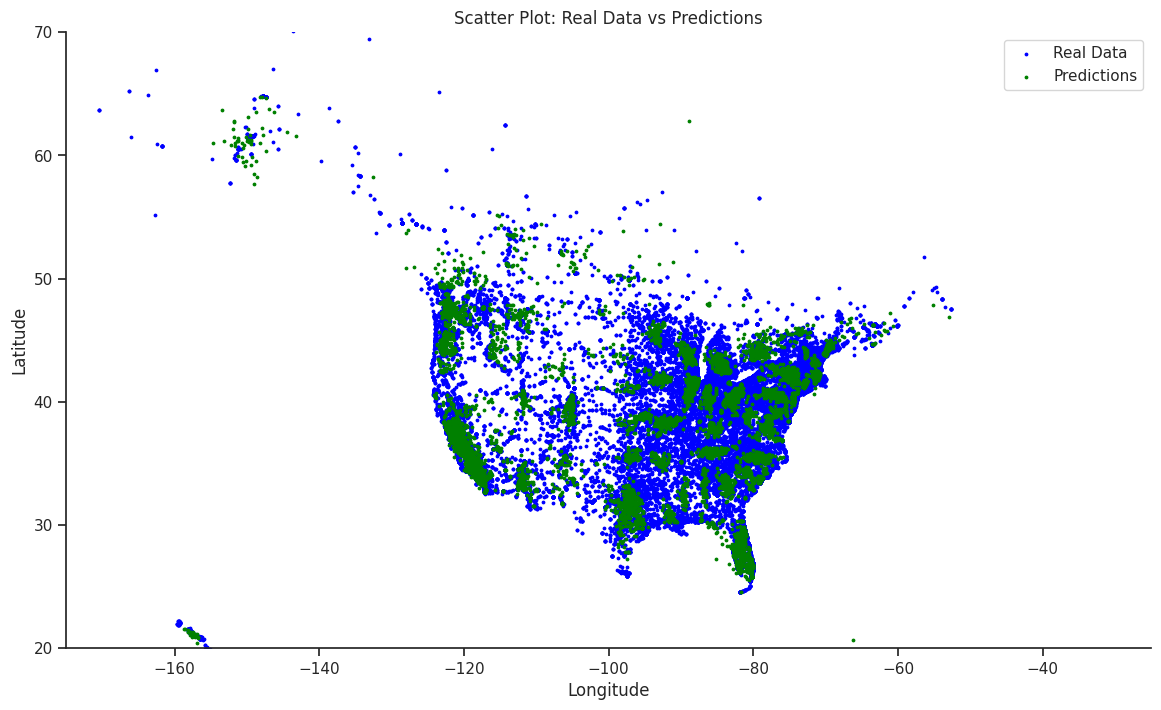

In [48]:
# Plot: Visualised Real Data and Predict Data
plt.figure(figsize=(14, 8))
plt.scatter(ufo_cop['longitude'], ufo_cop['latitude'], color='blue', label='Real Data', s=3)
mask = ~ufo_cop['predict_latitude_ufo'].isnull() & ~ufo_cop['predict_longitude_ufo'].isnull()
plt.scatter(ufo_cop.loc[mask, 'predict_longitude_ufo'], ufo_cop.loc[mask, 'predict_latitude_ufo'], color='green', label='Predictions', s=3)
plt.title('Scatter Plot: Real Data vs Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-175, -25)
plt.ylim(20, 70)
plt.legend()
plt.show()
